In [148]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import seaborn as sns
from sklearn.utils import class_weight

In [149]:
#%% Configuration
IMG_SIZE = (224, 224)  # ResNet50 input size
BATCH_SIZE = 32
EPOCHS = 20
SEED = 42
CLASSES = ['normal', 'benign', 'malignant']
NUM_CLASSES = len(CLASSES)
DATA_DIR = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'


In [150]:
# Set random seeds for reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Without Using the mask

# Data Loading and Pre-Processing

In [151]:
def load_and_preprocess_data(data_dir):
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(CLASSES):
        class_dir = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_dir):
            if img_file.endswith('.png') and '_mask' not in img_file:
                img_path = os.path.join(class_dir, img_file)
                
                # Load and preprocess image
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, IMG_SIZE)
                img = tf.keras.applications.resnet50.preprocess_input(img)  # ResNet50 preprocessing
                
                images.append(img.numpy())
                labels.append(class_idx)
    
    return np.array(images), np.array(labels)

In [152]:
X, y = load_and_preprocess_data(DATA_DIR)

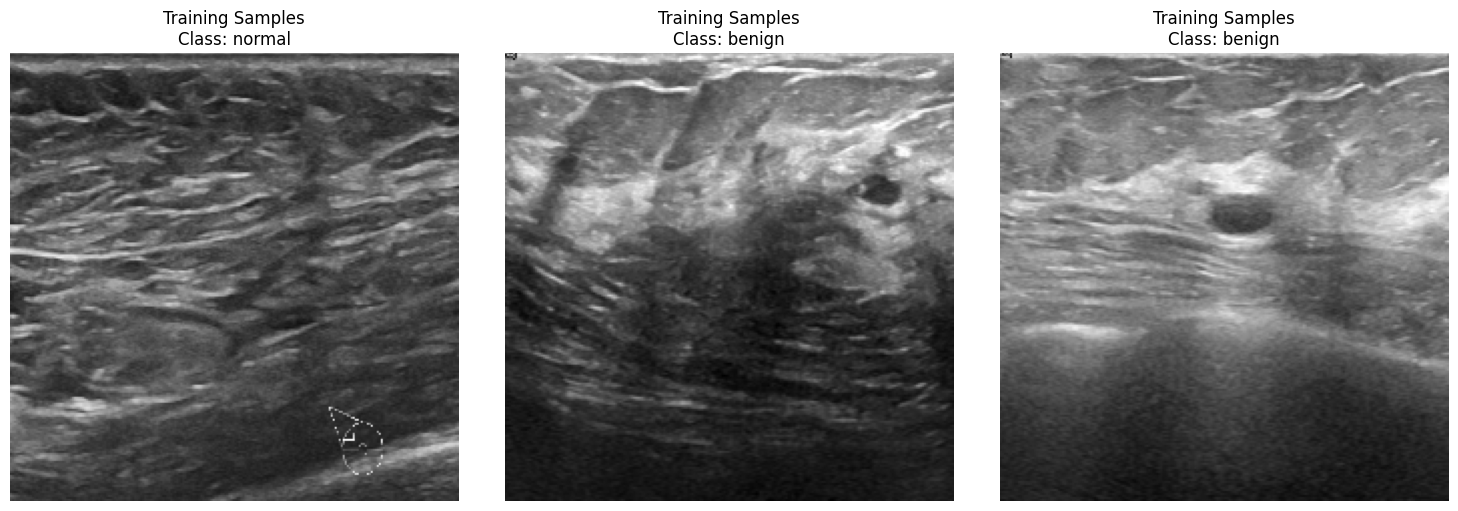

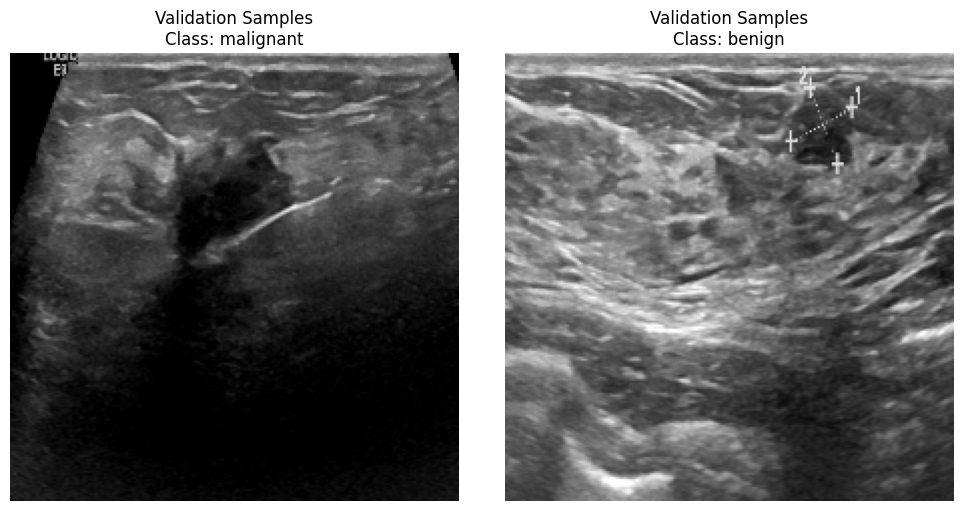

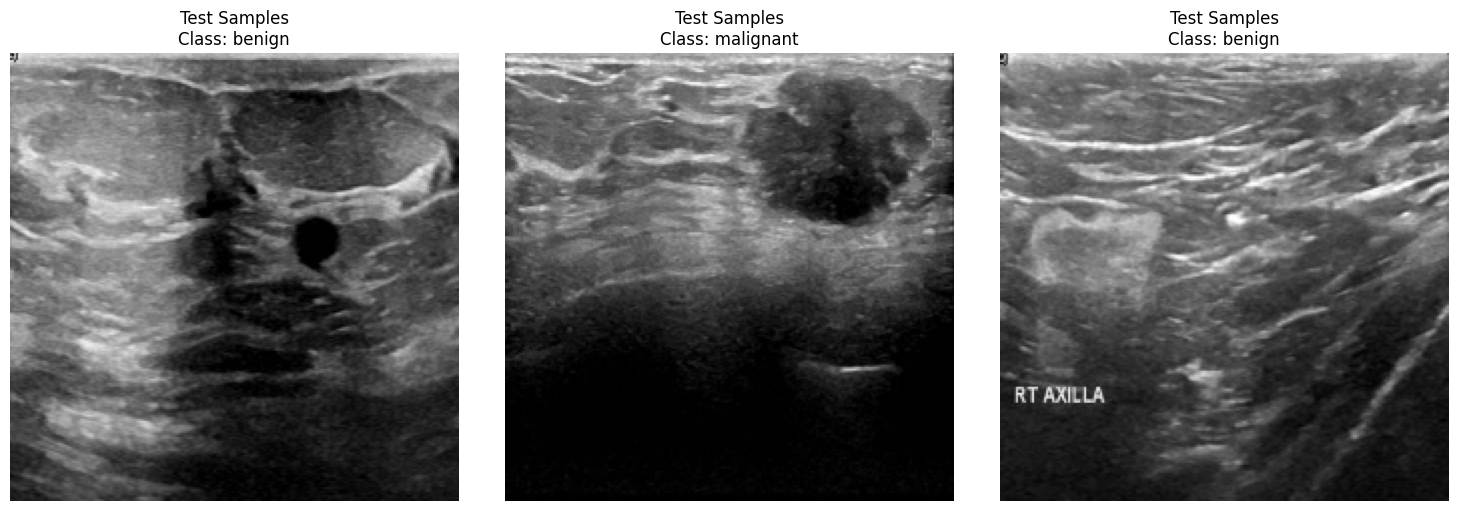

In [153]:
def plot_samples(dataset, title):
    plt.figure(figsize=(15, 5))
    for i, (image, label) in enumerate(dataset.take(3)):
        plt.subplot(1, 3, i+1)
        plt.imshow(image[0].numpy())
        plt.title(f"{title}\nClass: {CLASSES[label[0].numpy()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(train_dataset, "Training Samples")
plot_samples(val_dataset, "Validation Samples")
plot_samples(test_dataset, "Test Samples")

Sample Training Images:


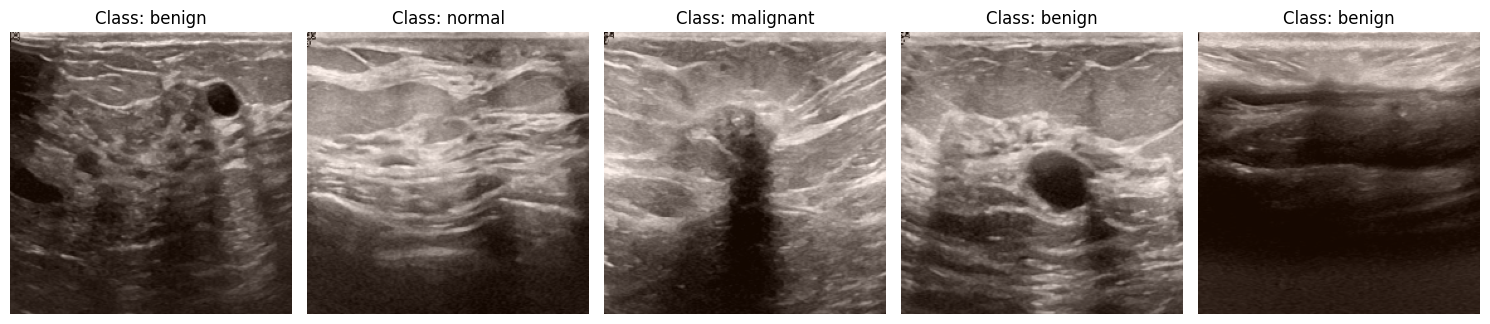

In [156]:
#%% Data Visualization
def plot_sample_images(images, labels, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        label = class_names[np.argmax(labels[idx])]  # Convert one-hot to class name
        
        # Rescale image for display
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot sample images from the training set
print("Sample Training Images:")
plot_sample_images(X_train, y_train, CLASSES)

Class Distribution in Training Set:


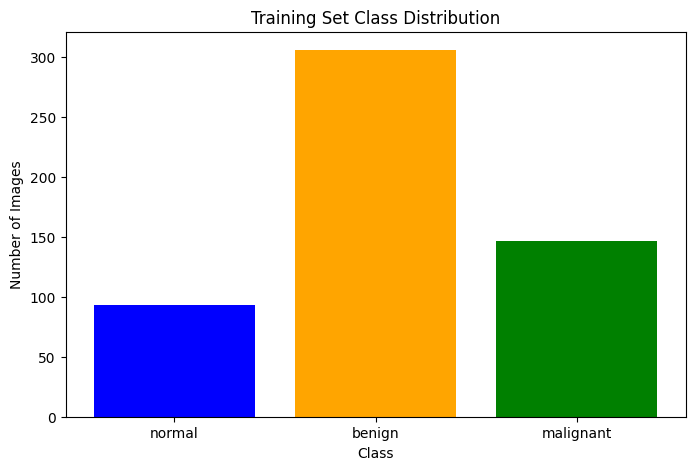

Class Distribution in Validation Set:


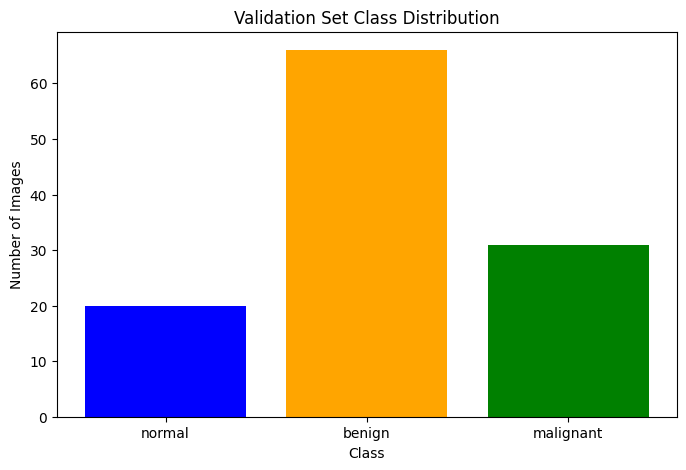

Class Distribution in Test Set:


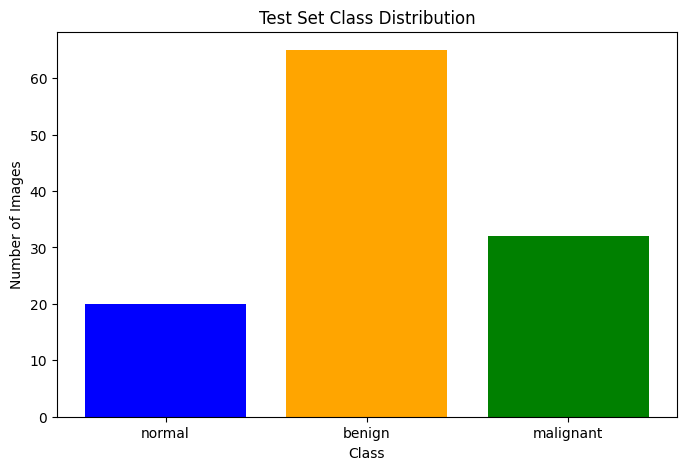

In [157]:
#%% Class Distribution Plotting
def plot_class_distribution(labels, class_names, title):
    class_counts = np.sum(labels, axis=0)  # Sum one-hot encoded labels
    plt.figure(figsize=(8, 5))
    plt.bar(class_names, class_counts, color=['blue', 'orange', 'green'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

# Plot class distribution for train, validation, and test sets
print("Class Distribution in Training Set:")
plot_class_distribution(y_train, CLASSES, "Training Set Class Distribution")

print("Class Distribution in Validation Set:")
plot_class_distribution(y_val, CLASSES, "Validation Set Class Distribution")

print("Class Distribution in Test Set:")
plot_class_distribution(y_test, CLASSES, "Test Set Class Distribution")

In [158]:
# Convert labels to one-hot encoding
y_onehot = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_onehot, test_size=0.3, stratify=y_onehot, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

#%% Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()  # No augmentation for validation/test


# Model Building

In [159]:
def build_pretrained_model(input_shape, num_classes):
    base_model = ResNet50(
        include_top=False,  # Exclude the fully connected layers at the top
        weights='imagenet',  # Load pretrained weights
        input_shape=input_shape
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom classification head
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

model = build_pretrained_model((IMG_SIZE[0], IMG_SIZE[1], 3), NUM_CLASSES)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [160]:
base_model = model.layers[0]  # ResNet50 base model
base_model.trainable = True

# Fine-tune only the last few layers
for layer in base_model.layers[:-10]:  # Freeze all but the last 10 layers
    layer.trainable = False

AttributeError: 'InputLayer' object has no attribute 'layers'

In [161]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [139]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_pretrained_model.keras', save_best_only=True)
]

# Training

In [170]:
y_train_classes = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights = dict(enumerate(class_weights))

In [179]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=30,
    #callbacks=callbacks,
    class_weight = class_weights
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.7481 - loss: 0.4725 - precision_10: 0.7778 - recall_10: 0.7146 - val_accuracy: 0.7350 - val_loss: 0.5498 - val_precision_10: 0.8100 - val_recall_10: 0.6923
Epoch 2/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5312 - loss: 0.8412 - precision_10: 0.5667 - recall_10: 0.5312

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5312 - loss: 0.8412 - precision_10: 0.5667 - recall_10: 0.5312 - val_accuracy: 0.7436 - val_loss: 0.5472 - val_precision_10: 0.8039 - val_recall_10: 0.7009
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.7523 - loss: 0.5262 - precision_10: 0.7787 - recall_10: 0.7135 - val_accuracy: 0.7607 - val_loss: 0.5551 - val_precision_10: 0.8119 - val_recall_10: 0.7009
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 1.0145 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_accuracy: 0.7607 - val_loss: 0.5527 - val_precision_10: 0.8039 - val_recall_10: 0.7009
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.7284 - loss: 0.5515 - precision_10: 0.7760 - recall_10: 0.6932 - val_accuracy: 0.7692 - val_loss: 0.5487 - val_precision_10: 0.8095 - val_recall_10: 0.7265
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7812 - loss: 0.4442 - precision_10: 0.8571 - rec

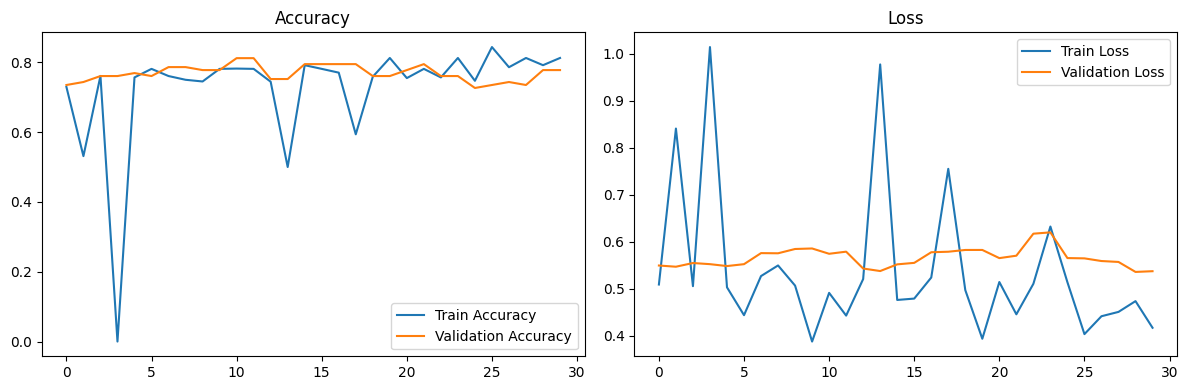

In [180]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7903 - loss: 0.4984 - precision_10: 0.8064 - recall_10: 0.7696

Test Accuracy: 77.78%
Test Precision: 80.00%
Test Recall: 75.21%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

Classification Report:
              precision    recall  f1-score   support

      normal       0.19      0.25      0.21        20
      benign       0.50      0.43      0.46        65
   malignant       0.26      0.28      0.27        32

    accuracy                           0.36       117
   macro avg       0.32      0.32      0.32       117
weighted avg       0.38      0.36      0.37       117



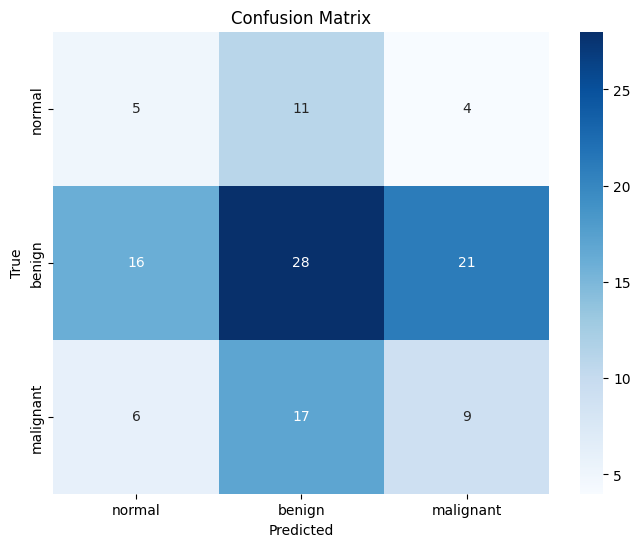

In [181]:
# Test set evaluation
test_loss, test_acc, test_prec, test_rec = model.evaluate(val_datagen.flow(X_test, y_test))
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Precision: {test_prec:.2%}")
print(f"Test Recall: {test_rec:.2%}")

# Classification report
y_pred = model.predict(val_datagen.flow(X_test, y_test))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASSES))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Exploiting The Existence of the mask

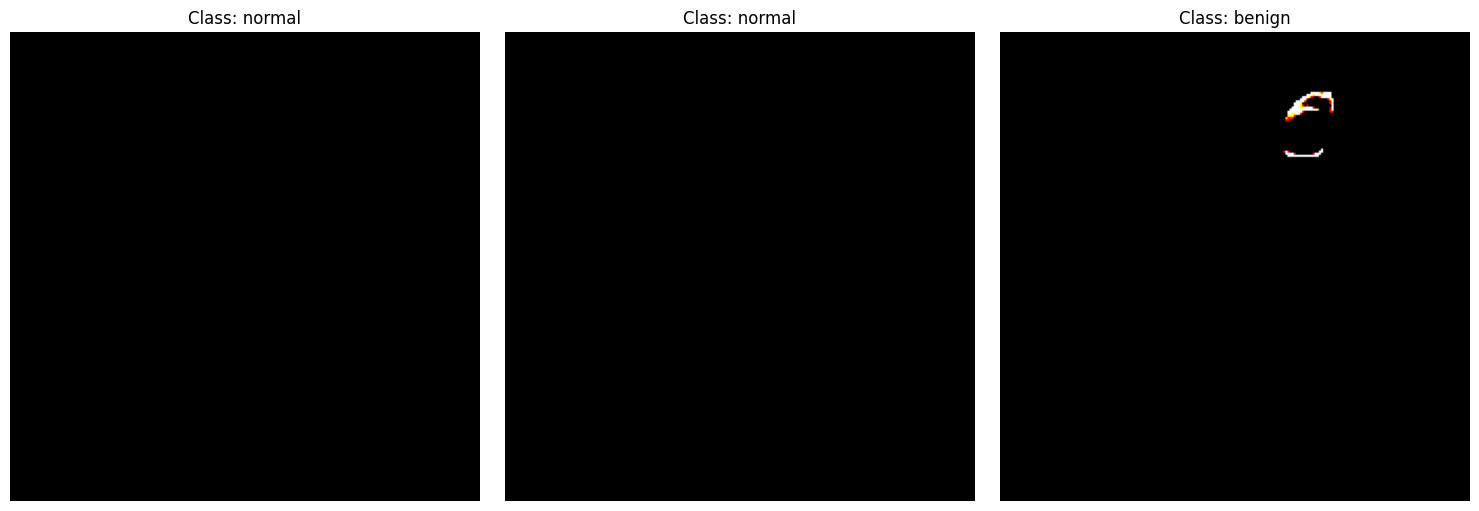

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 797ms/step - accuracy: 0.6975 - loss: 0.9716 - precision_11: 0.7168 - recall_11: 0.6832 - val_accuracy: 0.9231 - val_loss: 0.2413 - val_precision_11: 0.9231 - val_recall_11: 0.9231
Epoch 2/20
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9375 - loss: 0.2828 - precision_11: 0.9375 - recall_11: 0.9375

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9375 - loss: 0.2828 - precision_11: 0.9375 - recall_11: 0.9375 - val_accuracy: 0.9231 - val_loss: 0.2194 - val_precision_11: 0.9231 - val_recall_11: 0.9231
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - accuracy: 0.9529 - loss: 0.2255 - precision_11: 0.9592 - recall_11: 0.9418 - val_accuracy: 0.9487 - val_loss: 0.1183 - val_precision_11: 0.9487 - val_recall_11: 0.9487
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9062 - loss: 0.2103 - precision_11: 0.9355 - recall_11: 0.9062 - val_accuracy: 0.9573 - val_loss: 0.1215 - val_precision_11: 0.9573 - val_recall_11: 0.9573
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.9392 - loss: 0.1473 - precision_11: 0.9396 - recall_11: 0.9392 - val_accuracy: 0.9402 - val_loss: 0.1262 - val_precision_11: 0.9402 - val_recall_11: 0.9402
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9688 - loss: 0.0743 - precision_11: 0.9688 - recall_11: 0.96

In [183]:

#%% Enhanced Data Loading with Mask Application  # NEW
def load_and_preprocess_data(data_dir):
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(CLASSES):
        class_dir = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_dir):
            if img_file.endswith('.png') and '_mask' not in img_file:
                img_path = os.path.join(class_dir, img_file)
                mask_path = os.path.join(class_dir, img_file.replace('.png', '_mask.png'))  # NEW
                
                # Load image and mask
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, IMG_SIZE)
                
                # Load and process mask  # NEW
                mask = tf.io.read_file(mask_path)
                mask = tf.image.decode_png(mask, channels=1)
                mask = tf.image.resize(mask, IMG_SIZE)
                mask = tf.cast(mask > 0, tf.float32)  # Binarize mask
                
                # Apply mask to image  # NEW
                masked_img = img * mask  # Element-wise multiplication
                
                # Preprocess after masking  # NEW
                masked_img = tf.keras.applications.resnet50.preprocess_input(masked_img)
                
                images.append(masked_img.numpy())
                labels.append(class_idx)
    
    return np.array(images), np.array(labels)

#%% Class Weight Calculation  # NEW
def calculate_class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(y),
                                                     y=y)
    return dict(enumerate(class_weights))


X, y = load_and_preprocess_data(DATA_DIR)
class_weights = calculate_class_weights(y)  # NEW

# Convert labels to one-hot
y_onehot = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_onehot, test_size=0.3, stratify=y_onehot, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

#%% Mask Visualization  # NEW
def visualize_masked_samples(images, labels, num_samples=3):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = (images[idx] + 1) / 2  # Reverse ResNet preprocessing for display
        label = CLASSES[np.argmax(labels[idx])]
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Class: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_masked_samples(X_train, y_train)  # NEW

#%% Rest of your original code remains the same until training:
#%% Model Compilation
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

#%% Training with Class Weights  # NEW
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights  # NEW
)

# Keep the rest of your evaluation code unchanged

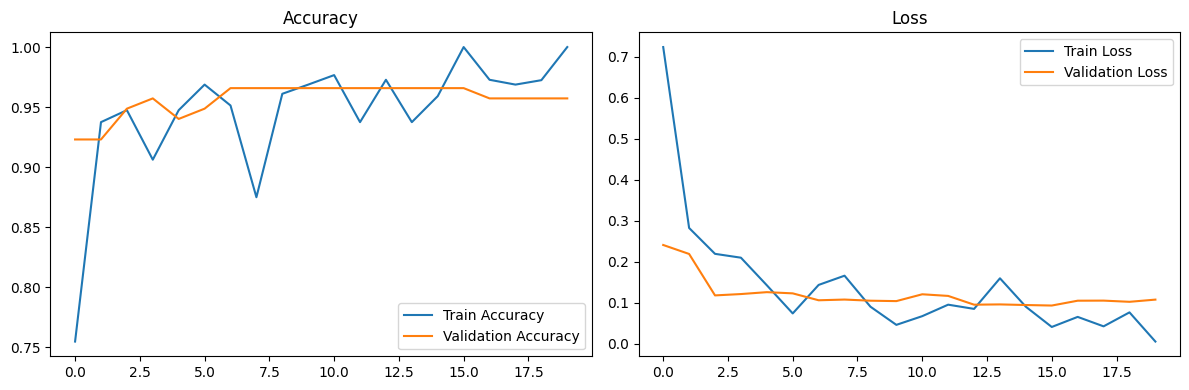

In [184]:
plot_training_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9817 - loss: 0.0651 - precision_11: 0.9817 - recall_11: 0.9817

Test Accuracy: 98.29%
Test Precision: 98.29%
Test Recall: 98.29%
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 

Classification Report:
              precision    recall  f1-score   support

      normal       0.15      0.15      0.15        20
      benign       0.57      0.57      0.57        65
   malignant       0.41      0.41      0.41        32

    accuracy                           0.45       117
   macro avg       0.38      0.38      0.38       117
weighted avg       0.45      0.45      0.45       117



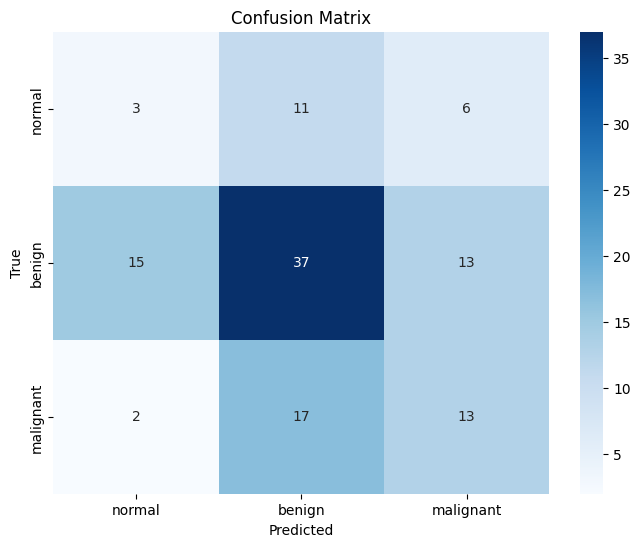

In [185]:
# Test set evaluation
test_loss, test_acc, test_prec, test_rec = model.evaluate(val_datagen.flow(X_test, y_test))
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Precision: {test_prec:.2%}")
print(f"Test Recall: {test_rec:.2%}")

# Classification report
y_pred = model.predict(val_datagen.flow(X_test, y_test))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASSES))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [187]:

model.save('pretrained_breast_cancer_model.h5')

#%% Deployment Predictor
def predict_breast_cancer(img_path, model):
    # Load and preprocess image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    
    # Make prediction
    probs = model.predict(img)[0]
    class_idx = np.argmax(probs)
    
    return {
        'class': CLASSES[class_idx],
        'confidence': float(probs[class_idx]),
        'probabilities': {c: float(p) for c, p in zip(CLASSES, probs)}
    }

# Example usage:
# result = predict_breast_cancer('path/to/new_image.png', model)
# print(result)